# 🤖 ML RAG System v2.0 - With Fine-Tuned Embeddings

A Retrieval-Augmented Generation (RAG) system with **fine-tuned embeddings** for improved retrieval.

## New Features in v2.0:
- 🎯 **Embedding Fine-Tuning** using Groq LLM for synthetic data generation
- 📊 **Evaluation Metrics**: Recall@K, MRR, NDCG
- 📈 **Before/After Comparison** of retrieval quality

## Architecture:
1. Generate synthetic query-document pairs using Groq LLM
2. Fine-tune embedding model with contrastive learning
3. Rebuild FAISS index with fine-tuned embeddings
4. Evaluate and compare retrieval performance

---

## 1. Installation & Setup

In [1]:
# Install required packages
!pip install -q --upgrade langchain langchain-community langchain-groq langchain-huggingface
!pip install -q --upgrade langchain-text-splitters langchain-core
!pip install -q faiss-cpu sentence-transformers
!pip install -q PyMuPDF arxiv beautifulsoup4 requests
!pip install -q fastapi uvicorn python-multipart pyngrok nest-asyncio
!pip install -q python-dotenv pydantic
!pip install -q transformers torch torchaudio scipy datasets
!pip install -q gradio Pillow
!pip install -q matplotlib seaborn pandas  # For evaluation visualization

print('\n⚠️ After running this cell, go to Runtime -> Restart runtime, then continue')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.9/475.9 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 79.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 k

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import standard libraries
import os
import re
import json
import random
import logging
import numpy as np
from pathlib import Path
from typing import List, Optional, Dict, Any, Tuple
from dataclasses import dataclass, field
from datetime import datetime
from io import BytesIO
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✅ Imports complete")

✅ Imports complete


## 2. Configuration

In [4]:
# @title API Keys Configuration { display-mode: "form" }
GROQ_API_KEY = ""  # @param {type:"string"}
HUGGINGFACE_API_KEY = ""  # @param {type:"string"} (Optional)

os.environ["GROQ_API_KEY"] = GROQ_API_KEY
if HUGGINGFACE_API_KEY:
    os.environ["HUGGINGFACE_API_KEY"] = HUGGINGFACE_API_KEY

print("✅ API keys configured!" if GROQ_API_KEY else "⚠️ Please enter your Groq API key above")

✅ API keys configured!


In [5]:
@dataclass
class Config:
    """Central configuration for the ML RAG System."""
    groq_api_key: str = ""
    huggingface_api_key: str = ""
    llm_model: str = "llama-3.3-70b-versatile"
    base_embedding_model: str = "sentence-transformers/all-MiniLM-L6-v2"
    fine_tuned_embedding_path: str = "./fine_tuned_embeddings"
    chunk_size: int = 1000
    chunk_overlap: int = 200
    top_k_results: int = 5
    knowledge_base_dir: str = "./knowledge_base"
    faiss_index_path: str = "./faiss_index"
    faiss_finetuned_index_path: str = "./faiss_index_finetuned"
    training_data_path: str = "./embedding_training_data.jsonl"
    eval_data_path: str = "./embedding_eval_data.jsonl"
    api_host: str = "0.0.0.0"
    api_port: int = 8000

    # Fine-tuning hyperparameters
    ft_epochs: int = 3
    ft_batch_size: int = 16
    ft_learning_rate: float = 2e-5
    ft_warmup_steps: int = 100
    ft_num_hard_negatives: int = 5

    @classmethod
    def from_env(cls) -> "Config":
        return cls(
            groq_api_key=os.getenv("GROQ_API_KEY", ""),
            huggingface_api_key=os.getenv("HUGGINGFACE_API_KEY", ""),
        )

    def ensure_directories(self):
        Path(self.knowledge_base_dir).mkdir(parents=True, exist_ok=True)
        Path(self.faiss_index_path).mkdir(parents=True, exist_ok=True)
        Path(self.fine_tuned_embedding_path).mkdir(parents=True, exist_ok=True)

config = Config.from_env()

# Set Google Drive paths
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/ML_RAG_KnowledgeBase"
config.knowledge_base_dir = f"{DRIVE_PROJECT_PATH}/knowledge_base"
config.faiss_index_path = f"{DRIVE_PROJECT_PATH}/faiss_index"
config.faiss_finetuned_index_path = f"{DRIVE_PROJECT_PATH}/faiss_index_finetuned"
config.fine_tuned_embedding_path = f"{DRIVE_PROJECT_PATH}/fine_tuned_embeddings"
config.training_data_path = f"{DRIVE_PROJECT_PATH}/embedding_training_data.jsonl"
config.eval_data_path = f"{DRIVE_PROJECT_PATH}/embedding_eval_data.jsonl"

config.ensure_directories()
print(f"📁 Knowledge base: {config.knowledge_base_dir}")
print(f"📁 FAISS index (baseline): {config.faiss_index_path}")
print(f"📁 FAISS index (fine-tuned): {config.faiss_finetuned_index_path}")
print(f"📁 Fine-tuned model: {config.fine_tuned_embedding_path}")

📁 Knowledge base: /content/drive/MyDrive/ML_RAG_KnowledgeBase/knowledge_base
📁 FAISS index (baseline): /content/drive/MyDrive/ML_RAG_KnowledgeBase/faiss_index
📁 FAISS index (fine-tuned): /content/drive/MyDrive/ML_RAG_KnowledgeBase/faiss_index_finetuned
📁 Fine-tuned model: /content/drive/MyDrive/ML_RAG_KnowledgeBase/fine_tuned_embeddings


## 3. Vector Store Manager (Supports Both Baseline & Fine-tuned)

In [7]:
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.documents import Document
from sentence_transformers import SentenceTransformer

class VectorStoreManager:
    """Manages FAISS vector store for document embeddings."""

    def __init__(self, embedding_model: str, index_path: str):
        self.embedding_model_name = embedding_model
        self.index_path = Path(index_path)
        self._embeddings = None
        self._vector_store = None
        self._is_local_model = not embedding_model.startswith("sentence-transformers/")

    @property
    def embeddings(self):
        if self._embeddings is None:
            print(f"🔄 Loading embedding model: {self.embedding_model_name}...")
            self._embeddings = HuggingFaceEmbeddings(
                model_name=self.embedding_model_name,
                model_kwargs={'device': 'cuda' if torch.cuda.is_available() else 'cpu'},
                encode_kwargs={'normalize_embeddings': True}
            )
            print("✅ Embedding model loaded")
        return self._embeddings

    @property
    def is_loaded(self) -> bool:
        return self._vector_store is not None

    def load_index(self) -> bool:
        index_file = self.index_path / "index.faiss"
        if not index_file.exists():
            print(f"❌ Index not found at {index_file}")
            return False
        try:
            self._vector_store = FAISS.load_local(
                str(self.index_path),
                self.embeddings,
                allow_dangerous_deserialization=True
            )
            print(f"✅ Loaded index with {self.get_document_count()} documents")
            return True
        except Exception as e:
            print(f"❌ Failed to load index: {e}")
            return False

    def save_index(self):
        if self._vector_store is None:
            raise ValueError("No index to save")
        self.index_path.mkdir(parents=True, exist_ok=True)
        self._vector_store.save_local(str(self.index_path))
        print(f"✅ Saved index to {self.index_path}")

    def add_documents(self, documents: List[Document]) -> int:
        if not documents:
            return 0
        if self._vector_store is None:
            self._vector_store = FAISS.from_documents(documents, self.embeddings)
        else:
            self._vector_store.add_documents(documents)
        return len(documents)

    def search(self, query: str, top_k: int = 5) -> List[Document]:
        if self._vector_store is None:
            raise ValueError("No index loaded")
        return self._vector_store.similarity_search(query, k=top_k)

    def get_document_count(self) -> int:
        return self._vector_store.index.ntotal if self._vector_store else 0

    def get_retriever(self, search_kwargs: dict = None):
        if self._vector_store is None:
            raise ValueError("No index loaded")
        return self._vector_store.as_retriever(search_kwargs=search_kwargs or {"k": 5})

    def get_all_documents(self) -> List[Document]:
        """Extract all documents from the vector store."""
        if self._vector_store is None:
            return []
        docstore = self._vector_store.docstore
        index_to_id = self._vector_store.index_to_docstore_id
        documents = []
        for idx in range(len(index_to_id)):
            doc_id = index_to_id[idx]
            doc = docstore.search(doc_id)
            if doc:
                documents.append(doc)
        return documents

print("✅ VectorStoreManager defined")

✅ VectorStoreManager defined


## 4. Load Existing FAISS Index (Baseline)

In [8]:
# Load baseline vector store
baseline_vector_store = VectorStoreManager(
    embedding_model=config.base_embedding_model,
    index_path=config.faiss_index_path
)

if baseline_vector_store.load_index():
    print(f"📊 Baseline index loaded with {baseline_vector_store.get_document_count()} documents")
else:
    print("⚠️ No baseline index found. Please build the knowledge base first.")

🔄 Loading embedding model: sentence-transformers/all-MiniLM-L6-v2...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Embedding model loaded
✅ Loaded index with 61242 documents
📊 Baseline index loaded with 61242 documents


## 5. Synthetic Training Data Generation using Groq LLM

We use Groq's Llama model to generate synthetic queries for each document chunk.
This creates (query, positive_document) pairs for contrastive learning.

In [9]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
import time

class SyntheticDataGenerator:
    """Generate synthetic query-document pairs using Groq LLM."""

    def __init__(self, groq_api_key: str, model: str = "llama-3.3-70b-versatile"):
        self.llm = ChatGroq(model=model, api_key=groq_api_key, temperature=0.7)
        self.prompt = ChatPromptTemplate.from_template(
            """You are a helpful assistant that generates search queries.

Given the following document about machine learning, generate 3 diverse search queries
that a student might use to find this information. The queries should be:
1. A direct question about the main topic
2. A conceptual question that this document would answer
3. A practical/application-based question

Document:
{document}

Return ONLY the 3 queries, one per line, without numbering or extra text."""
        )
        self.chain = self.prompt | self.llm

    def generate_queries(self, document: str, max_retries: int = 3) -> List[str]:
        """Generate synthetic queries for a document."""
        for attempt in range(max_retries):
            try:
                # Truncate document if too long
                doc_text = document[:2000] if len(document) > 2000 else document
                response = self.chain.invoke({"document": doc_text})
                queries = [q.strip() for q in response.content.strip().split('\n') if q.strip()]
                return queries[:3]  # Return max 3 queries
            except Exception as e:
                if "rate_limit" in str(e).lower():
                    time.sleep(2 ** attempt)  # Exponential backoff
                else:
                    print(f"Error generating queries: {e}")
                    return []
        return []

print("✅ SyntheticDataGenerator defined")

✅ SyntheticDataGenerator defined


In [10]:
def generate_training_data(
    vector_store: VectorStoreManager,
    generator: SyntheticDataGenerator,
    output_path: str,
    num_samples: int = 1000,
    eval_split: float = 0.1
) -> Tuple[str, str]:
    """
    Generate training data from existing documents.

    Returns paths to training and evaluation data files.
    """
    documents = vector_store.get_all_documents()

    if not documents:
        raise ValueError("No documents found in vector store")

    # Sample documents if we have more than needed
    if len(documents) > num_samples:
        documents = random.sample(documents, num_samples)

    print(f"📝 Generating synthetic queries for {len(documents)} documents...")

    training_data = []

    for i, doc in enumerate(tqdm(documents, desc="Generating queries")):
        queries = generator.generate_queries(doc.page_content)

        for query in queries:
            training_data.append({
                "query": query,
                "positive": doc.page_content,
                "metadata": doc.metadata
            })

        # Rate limiting
        if (i + 1) % 10 == 0:
            time.sleep(1)

    # Shuffle and split
    random.shuffle(training_data)
    split_idx = int(len(training_data) * (1 - eval_split))

    train_data = training_data[:split_idx]
    eval_data = training_data[split_idx:]

    # Save training data
    train_path = output_path.replace('.jsonl', '_train.jsonl')
    with open(train_path, 'w') as f:
        for item in train_data:
            f.write(json.dumps(item) + '\n')

    # Save evaluation data
    eval_path = output_path.replace('.jsonl', '_eval.jsonl')
    with open(eval_path, 'w') as f:
        for item in eval_data:
            f.write(json.dumps(item) + '\n')

    print(f"✅ Generated {len(train_data)} training samples")
    print(f"✅ Generated {len(eval_data)} evaluation samples")
    print(f"📁 Training data saved to: {train_path}")
    print(f"📁 Evaluation data saved to: {eval_path}")

    return train_path, eval_path

print("✅ Training data generator defined")

✅ Training data generator defined


In [11]:
# Generate training data (run this once)
# This may take a while depending on the number of documents

GENERATE_NEW_DATA = True  # Set to True to generate new training data

if GENERATE_NEW_DATA and config.groq_api_key:
    generator = SyntheticDataGenerator(config.groq_api_key)
    train_path, eval_path = generate_training_data(
        baseline_vector_store,
        generator,
        config.training_data_path,
        num_samples=500,  # Adjust based on your needs
        eval_split=0.1
    )
else:
    train_path = config.training_data_path.replace('.jsonl', '_train.jsonl')
    eval_path = config.training_data_path.replace('.jsonl', '_eval.jsonl')
    print(f"📁 Using existing training data from: {train_path}")

📝 Generating synthetic queries for 500 documents...


Generating queries: 100%|██████████| 500/500 [46:08<00:00,  5.54s/it]

✅ Generated 672 training samples
✅ Generated 75 evaluation samples
📁 Training data saved to: /content/drive/MyDrive/ML_RAG_KnowledgeBase/embedding_training_data_train.jsonl
📁 Evaluation data saved to: /content/drive/MyDrive/ML_RAG_KnowledgeBase/embedding_training_data_eval.jsonl


## 6. Embedding Fine-Tuning with Contrastive Learning

We fine-tune the embedding model using:
- **Multiple Negatives Ranking Loss** (InfoNCE)
- **Hard Negative Mining** from the existing index

In [12]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from torch.utils.data import DataLoader

class EmbeddingFineTuner:
    """Fine-tune embedding model using contrastive learning."""

    def __init__(
        self,
        base_model: str = "sentence-transformers/all-MiniLM-L6-v2",
        device: str = None
    ):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"🔄 Loading base model: {base_model}")
        self.model = SentenceTransformer(base_model, device=self.device)
        print(f"✅ Model loaded on {self.device}")

    def load_training_data(self, train_path: str) -> List[InputExample]:
        """Load training data as InputExamples."""
        examples = []
        with open(train_path, 'r') as f:
            for line in f:
                item = json.loads(line)
                # For MultipleNegativesRankingLoss, we need (query, positive) pairs
                examples.append(InputExample(
                    texts=[item['query'], item['positive']]
                ))
        print(f"✅ Loaded {len(examples)} training examples")
        return examples

    def mine_hard_negatives(
        self,
        train_data: List[Dict],
        vector_store: VectorStoreManager,
        num_negatives: int = 5
    ) -> List[InputExample]:
        """Mine hard negatives from the vector store."""
        examples = []

        for item in tqdm(train_data, desc="Mining hard negatives"):
            query = item['query']
            positive = item['positive']

            # Get top-k similar documents (potential hard negatives)
            results = vector_store.search(query, top_k=num_negatives + 5)

            # Filter out the positive document
            negatives = [
                doc.page_content for doc in results
                if doc.page_content != positive
            ][:num_negatives]

            if negatives:
                # Create triplet: (query, positive, negative)
                for neg in negatives:
                    examples.append(InputExample(
                        texts=[query, positive, neg]
                    ))

        print(f"✅ Created {len(examples)} examples with hard negatives")
        return examples

    def train(
        self,
        train_examples: List[InputExample],
        output_path: str,
        epochs: int = 3,
        batch_size: int = 16,
        warmup_steps: int = 100,
        use_hard_negatives: bool = False
    ):
        """Fine-tune the embedding model."""
        print(f"\n🚀 Starting fine-tuning...")
        print(f"   Epochs: {epochs}")
        print(f"   Batch size: {batch_size}")
        print(f"   Training examples: {len(train_examples)}")

        train_dataloader = DataLoader(
            train_examples,
            shuffle=True,
            batch_size=batch_size
        )

        # Choose loss function based on data format
        if use_hard_negatives:
            # TripletLoss for (query, positive, negative) triplets
            train_loss = losses.TripletLoss(model=self.model)
        else:
            # MultipleNegativesRankingLoss for (query, positive) pairs
            # Uses in-batch negatives
            train_loss = losses.MultipleNegativesRankingLoss(model=self.model)

        # Train the model
        self.model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            epochs=epochs,
            warmup_steps=warmup_steps,
            output_path=output_path,
            show_progress_bar=True
        )

        print(f"\n✅ Fine-tuning complete!")
        print(f"📁 Model saved to: {output_path}")

        return output_path

print("✅ EmbeddingFineTuner defined")

✅ EmbeddingFineTuner defined


In [13]:
# Fine-tune the embedding model
FINE_TUNE_MODEL = True  # Set to True to fine-tune

if FINE_TUNE_MODEL:
    # Initialize fine-tuner
    fine_tuner = EmbeddingFineTuner(base_model=config.base_embedding_model)

    # Load training data
    train_examples = fine_tuner.load_training_data(train_path)

    # Optional: Mine hard negatives for better training
    USE_HARD_NEGATIVES = False
    if USE_HARD_NEGATIVES:
        with open(train_path, 'r') as f:
            train_data = [json.loads(line) for line in f]
        train_examples = fine_tuner.mine_hard_negatives(
            train_data,
            baseline_vector_store,
            num_negatives=config.ft_num_hard_negatives
        )

    # Train
    fine_tuner.train(
        train_examples=train_examples,
        output_path=config.fine_tuned_embedding_path,
        epochs=config.ft_epochs,
        batch_size=config.ft_batch_size,
        warmup_steps=config.ft_warmup_steps,
        use_hard_negatives=USE_HARD_NEGATIVES
    )
else:
    print("⏭️ Skipping fine-tuning. Set FINE_TUNE_MODEL=True to train.")

🔄 Loading base model: sentence-transformers/all-MiniLM-L6-v2
✅ Model loaded on cuda
✅ Loaded 672 training examples

🚀 Starting fine-tuning...
   Epochs: 3
   Batch size: 16
   Training examples: 672


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


wandb: Detected [groq] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Step,Training Loss



✅ Fine-tuning complete!
📁 Model saved to: /content/drive/MyDrive/ML_RAG_KnowledgeBase/fine_tuned_embeddings


## 7. Rebuild FAISS Index with Fine-tuned Embeddings

In [14]:
def rebuild_index_with_finetuned_model(
    source_vector_store: VectorStoreManager,
    finetuned_model_path: str,
    output_index_path: str
) -> VectorStoreManager:
    """
    Rebuild FAISS index using fine-tuned embeddings.
    """
    print("📊 Extracting documents from source index...")
    documents = source_vector_store.get_all_documents()
    print(f"   Found {len(documents)} documents")

    print(f"\n🔄 Creating new index with fine-tuned embeddings...")
    finetuned_vector_store = VectorStoreManager(
        embedding_model=finetuned_model_path,
        index_path=output_index_path
    )

    # Add documents in batches
    batch_size = 500
    for i in tqdm(range(0, len(documents), batch_size), desc="Indexing"):
        batch = documents[i:i+batch_size]
        finetuned_vector_store.add_documents(batch)

    finetuned_vector_store.save_index()
    print(f"\n✅ Fine-tuned index created with {finetuned_vector_store.get_document_count()} documents")

    return finetuned_vector_store

print("✅ Index rebuilder defined")

✅ Index rebuilder defined


In [15]:
# Rebuild index with fine-tuned model
REBUILD_INDEX = True  # Set to True after fine-tuning

if REBUILD_INDEX and Path(config.fine_tuned_embedding_path).exists():
    finetuned_vector_store = rebuild_index_with_finetuned_model(
        source_vector_store=baseline_vector_store,
        finetuned_model_path=config.fine_tuned_embedding_path,
        output_index_path=config.faiss_finetuned_index_path
    )
else:
    # Try to load existing fine-tuned index
    finetuned_index_path = Path(config.faiss_finetuned_index_path)
    if (finetuned_index_path / "index.faiss").exists():
        print("📁 Loading existing fine-tuned index...")
        finetuned_vector_store = VectorStoreManager(
            embedding_model=config.fine_tuned_embedding_path,
            index_path=config.faiss_finetuned_index_path
        )
        finetuned_vector_store.load_index()
    else:
        finetuned_vector_store = None
        print("⚠️ No fine-tuned index found. Fine-tune and rebuild first.")

📊 Extracting documents from source index...
   Found 61242 documents

🔄 Creating new index with fine-tuned embeddings...


Indexing:   0%|          | 0/123 [00:00<?, ?it/s]

🔄 Loading embedding model: /content/drive/MyDrive/ML_RAG_KnowledgeBase/fine_tuned_embeddings...
✅ Embedding model loaded


Indexing: 100%|██████████| 123/123 [02:48<00:00,  1.37s/it]


✅ Saved index to /content/drive/MyDrive/ML_RAG_KnowledgeBase/faiss_index_finetuned

✅ Fine-tuned index created with 61242 documents


## 8. Evaluation Metrics

We evaluate retrieval quality using:
- **Recall@K**: Fraction of queries where the relevant document is in top-K
- **MRR (Mean Reciprocal Rank)**: Average of 1/rank of first relevant document
- **NDCG@K**: Normalized Discounted Cumulative Gain

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class RetrievalEvaluator:
    """Evaluate retrieval quality with multiple metrics."""

    def __init__(self, vector_store: VectorStoreManager):
        self.vector_store = vector_store

    def load_eval_data(self, eval_path: str) -> List[Dict]:
        """Load evaluation data."""
        eval_data = []
        with open(eval_path, 'r') as f:
            for line in f:
                eval_data.append(json.loads(line))
        return eval_data

    def recall_at_k(self, eval_data: List[Dict], k: int) -> float:
        """Calculate Recall@K."""
        hits = 0
        for sample in tqdm(eval_data, desc=f"Recall@{k}", leave=False):
            results = self.vector_store.search(sample['query'], top_k=k)
            retrieved_texts = [doc.page_content for doc in results]
            if sample['positive'] in retrieved_texts:
                hits += 1
        return hits / len(eval_data)

    def mrr_at_k(self, eval_data: List[Dict], k: int) -> float:
        """Calculate Mean Reciprocal Rank@K."""
        reciprocal_ranks = []
        for sample in tqdm(eval_data, desc=f"MRR@{k}", leave=False):
            results = self.vector_store.search(sample['query'], top_k=k)
            for rank, doc in enumerate(results, start=1):
                if doc.page_content == sample['positive']:
                    reciprocal_ranks.append(1.0 / rank)
                    break
            else:
                reciprocal_ranks.append(0.0)
        return sum(reciprocal_ranks) / len(reciprocal_ranks)

    def ndcg_at_k(self, eval_data: List[Dict], k: int) -> float:
        """Calculate NDCG@K (binary relevance)."""
        ndcg_scores = []
        for sample in tqdm(eval_data, desc=f"NDCG@{k}", leave=False):
            results = self.vector_store.search(sample['query'], top_k=k)

            # Binary relevance: 1 if positive, 0 otherwise
            relevances = [
                1.0 if doc.page_content == sample['positive'] else 0.0
                for doc in results
            ]

            # DCG
            dcg = sum(
                rel / np.log2(rank + 1)
                for rank, rel in enumerate(relevances, start=1)
            )

            # Ideal DCG (best case: relevant doc at rank 1)
            idcg = 1.0 / np.log2(2)  # = 1.0 for binary relevance

            ndcg_scores.append(dcg / idcg if idcg > 0 else 0.0)

        return sum(ndcg_scores) / len(ndcg_scores)

    def evaluate(self, eval_data: List[Dict], k_values: List[int] = [1, 3, 5, 10]) -> Dict:
        """Run full evaluation."""
        results = {}

        for k in k_values:
            print(f"\n📊 Evaluating at K={k}...")
            results[k] = {
                'Recall@K': self.recall_at_k(eval_data, k),
                'MRR@K': self.mrr_at_k(eval_data, k),
                'NDCG@K': self.ndcg_at_k(eval_data, k)
            }

        return results

print("✅ RetrievalEvaluator defined")

✅ RetrievalEvaluator defined


In [17]:
def compare_models(
    baseline_results: Dict,
    finetuned_results: Dict,
    k_values: List[int] = [1, 3, 5, 10]
):
    """Compare baseline vs fine-tuned model results."""

    # Create comparison dataframe
    data = []
    for k in k_values:
        for metric in ['Recall@K', 'MRR@K', 'NDCG@K']:
            data.append({
                'K': k,
                'Metric': metric,
                'Baseline': baseline_results[k][metric],
                'Fine-tuned': finetuned_results[k][metric],
                'Improvement': finetuned_results[k][metric] - baseline_results[k][metric]
            })

    df = pd.DataFrame(data)

    # Print results table
    print("\n" + "="*80)
    print("📊 RETRIEVAL EVALUATION RESULTS")
    print("="*80)

    for k in k_values:
        print(f"\n--- K = {k} ---")
        k_df = df[df['K'] == k]
        for _, row in k_df.iterrows():
            improvement_pct = (row['Improvement'] / row['Baseline'] * 100) if row['Baseline'] > 0 else 0
            arrow = "↑" if row['Improvement'] > 0 else "↓" if row['Improvement'] < 0 else "→"
            print(f"  {row['Metric']:10s}: Baseline={row['Baseline']:.4f} | Fine-tuned={row['Fine-tuned']:.4f} | {arrow} {abs(improvement_pct):.1f}%")

    return df

def plot_comparison(df: pd.DataFrame):
    """Plot comparison charts."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    metrics = ['Recall@K', 'MRR@K', 'NDCG@K']
    colors = ['#2ecc71', '#3498db']

    for idx, metric in enumerate(metrics):
        metric_df = df[df['Metric'] == metric]

        x = np.arange(len(metric_df))
        width = 0.35

        axes[idx].bar(x - width/2, metric_df['Baseline'], width, label='Baseline', color=colors[0], alpha=0.8)
        axes[idx].bar(x + width/2, metric_df['Fine-tuned'], width, label='Fine-tuned', color=colors[1], alpha=0.8)

        axes[idx].set_xlabel('K')
        axes[idx].set_ylabel('Score')
        axes[idx].set_title(metric)
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(metric_df['K'].values)
        axes[idx].legend()
        axes[idx].set_ylim(0, 1)

    plt.tight_layout()
    plt.savefig('retrieval_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("📁 Chart saved to: retrieval_comparison.png")

print("✅ Comparison functions defined")

✅ Comparison functions defined


## 9. Run Evaluation

In [18]:
# Run evaluation
K_VALUES = [1, 3, 5, 10]

# Load evaluation data
eval_path = config.training_data_path.replace('.jsonl', '_eval.jsonl')

if Path(eval_path).exists():
    print(f"📁 Loading evaluation data from: {eval_path}")

    # Evaluate baseline
    print("\n" + "="*50)
    print("🔵 EVALUATING BASELINE MODEL")
    print("="*50)

    baseline_evaluator = RetrievalEvaluator(baseline_vector_store)
    eval_data = baseline_evaluator.load_eval_data(eval_path)
    print(f"Loaded {len(eval_data)} evaluation samples")

    baseline_results = baseline_evaluator.evaluate(eval_data, K_VALUES)

    # Print baseline results
    print("\n📊 Baseline Results:")
    for k, metrics in baseline_results.items():
        print(f"  K={k}: Recall={metrics['Recall@K']:.4f}, MRR={metrics['MRR@K']:.4f}, NDCG={metrics['NDCG@K']:.4f}")
else:
    print(f"⚠️ Evaluation data not found at {eval_path}")
    print("Please generate training data first (Section 5).")

📁 Loading evaluation data from: /content/drive/MyDrive/ML_RAG_KnowledgeBase/embedding_training_data_eval.jsonl

🔵 EVALUATING BASELINE MODEL
Loaded 75 evaluation samples

📊 Evaluating at K=1...



📊 Evaluating at K=3...



📊 Evaluating at K=5...



📊 Evaluating at K=10...



📊 Baseline Results:
  K=1: Recall=0.1200, MRR=0.1200, NDCG=0.1200
  K=3: Recall=0.2000, MRR=0.1533, NDCG=0.1652
  K=5: Recall=0.2267, MRR=0.1600, NDCG=0.1767
  K=10: Recall=0.3333, MRR=0.1741, NDCG=0.2110



🟢 EVALUATING FINE-TUNED MODEL

📊 Evaluating at K=1...



📊 Evaluating at K=3...



📊 Evaluating at K=5...



📊 Evaluating at K=10...



📊 RETRIEVAL EVALUATION RESULTS

--- K = 1 ---
  Recall@K  : Baseline=0.1200 | Fine-tuned=0.1867 | ↑ 55.6%
  MRR@K     : Baseline=0.1200 | Fine-tuned=0.1867 | ↑ 55.6%
  NDCG@K    : Baseline=0.1200 | Fine-tuned=0.1867 | ↑ 55.6%

--- K = 3 ---
  Recall@K  : Baseline=0.2000 | Fine-tuned=0.2933 | ↑ 46.7%
  MRR@K     : Baseline=0.1533 | Fine-tuned=0.2311 | ↑ 50.7%
  NDCG@K    : Baseline=0.1652 | Fine-tuned=0.2470 | ↑ 49.5%

--- K = 5 ---
  Recall@K  : Baseline=0.2267 | Fine-tuned=0.4133 | ↑ 82.4%
  MRR@K     : Baseline=0.1600 | Fine-tuned=0.2584 | ↑ 61.5%
  NDCG@K    : Baseline=0.1767 | Fine-tuned=0.2963 | ↑ 67.7%

--- K = 10 ---
  Recall@K  : Baseline=0.3333 | Fine-tuned=0.4800 | ↑ 44.0%
  MRR@K     : Baseline=0.1741 | Fine-tuned=0.2676 | ↑ 53.7%
  NDCG@K    : Baseline=0.2110 | Fine-tuned=0.3182 | ↑ 50.8%


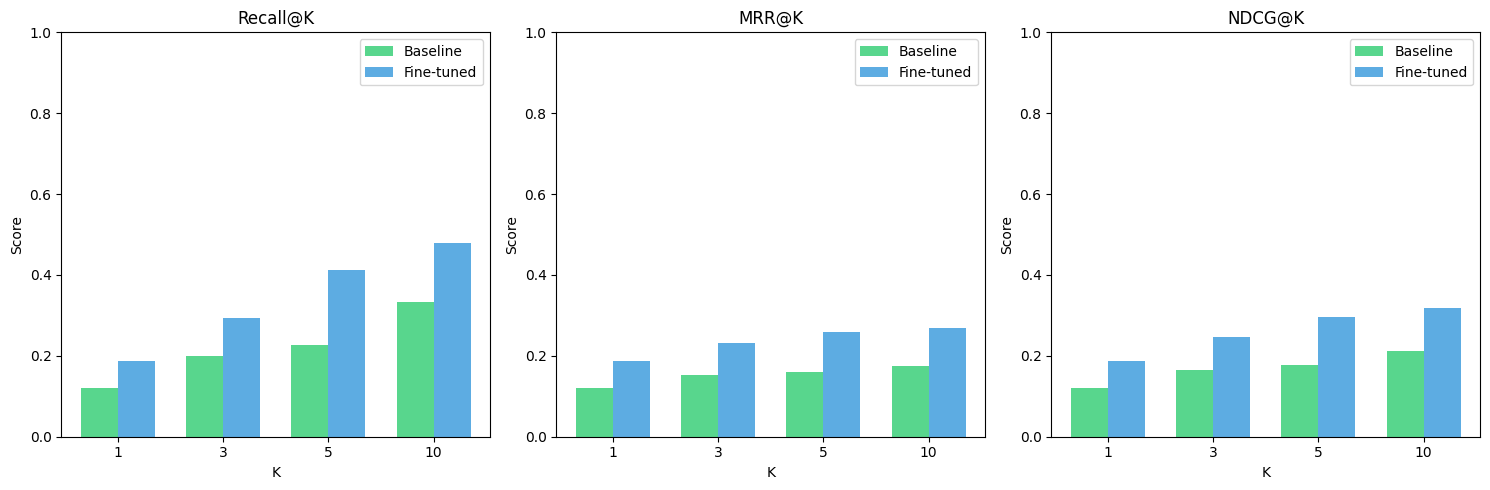

📁 Chart saved to: retrieval_comparison.png

📁 Results saved to: /content/drive/MyDrive/ML_RAG_KnowledgeBase/evaluation_results.json


In [19]:
# Evaluate fine-tuned model (if available)
if finetuned_vector_store is not None and Path(eval_path).exists():
    print("\n" + "="*50)
    print("🟢 EVALUATING FINE-TUNED MODEL")
    print("="*50)

    finetuned_evaluator = RetrievalEvaluator(finetuned_vector_store)
    finetuned_results = finetuned_evaluator.evaluate(eval_data, K_VALUES)

    # Compare results
    comparison_df = compare_models(baseline_results, finetuned_results, K_VALUES)

    # Plot comparison
    plot_comparison(comparison_df)

    # Save results
    results_path = f"{DRIVE_PROJECT_PATH}/evaluation_results.json"
    with open(results_path, 'w') as f:
        json.dump({
            'baseline': {str(k): v for k, v in baseline_results.items()},
            'finetuned': {str(k): v for k, v in finetuned_results.items()}
        }, f, indent=2)
    print(f"\n📁 Results saved to: {results_path}")
else:
    print("\n⚠️ Fine-tuned model not available for comparison.")
    print("Complete fine-tuning (Section 6) and rebuild index (Section 7) first.")

## 10. RAG Chain with Fine-tuned Embeddings

In [20]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

@dataclass
class RAGResponse:
    answer: str
    sources: List[str]
    context_chunks: List[Document] = field(default_factory=list)

def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)

class RAGChain:
    """RAG chain using Groq LLM."""

    def __init__(self, llm_model: str, retriever, groq_api_key: str):
        self.llm = ChatGroq(model=llm_model, api_key=groq_api_key, temperature=0.7)
        self.retriever = retriever
        self._setup_chain()

    def _setup_chain(self):
        system_prompt = """You are a helpful AI assistant specialized in machine learning.
Use the following context to answer the question. If you don't know, say so.
Always cite your sources when possible.

Context:
{context}

Question: {question}
"""
        prompt = ChatPromptTemplate.from_template(system_prompt)

        self.rag_chain = (
            RunnableParallel(context=self.retriever | format_docs, question=RunnablePassthrough())
            | prompt
            | self.llm
            | StrOutputParser()
        )

    def query(self, question: str) -> RAGResponse:
        docs = self.retriever.invoke(question)
        answer = self.rag_chain.invoke(question)
        sources = list(set(
            doc.metadata.get('source_file') or doc.metadata.get('source_url', 'Unknown')
            for doc in docs
        ))
        return RAGResponse(answer=answer, sources=sources, context_chunks=docs)

print("✅ RAGChain defined")

✅ RAGChain defined


In [21]:
# Initialize RAG chains
USE_FINETUNED = True  # Set to True to use fine-tuned embeddings

if config.groq_api_key:
    if USE_FINETUNED and finetuned_vector_store is not None:
        print("🟢 Using FINE-TUNED embeddings for RAG")
        active_vector_store = finetuned_vector_store
    else:
        print("🔵 Using BASELINE embeddings for RAG")
        active_vector_store = baseline_vector_store

    retriever = active_vector_store.get_retriever({"k": config.top_k_results})
    rag_chain = RAGChain(
        llm_model=config.llm_model,
        retriever=retriever,
        groq_api_key=config.groq_api_key
    )
    print("✅ RAG chain initialized!")
else:
    print("⚠️ Groq API key not set. Please configure in Section 2.")

🟢 Using FINE-TUNED embeddings for RAG
✅ RAG chain initialized!


In [22]:
# Test the RAG system
def ask(question: str) -> str:
    """Ask a question to the RAG system."""
    if rag_chain is None:
        return "❌ RAG system not initialized."

    print(f"🤔 Question: {question}\n")
    response = rag_chain.query(question)

    print(f"💡 Answer:\n{response.answer}\n")
    if response.sources:
        print(f"📚 Sources: {', '.join(response.sources)}")

    return response.answer

# Example query
ask("What is gradient descent and how does it work?")

🤔 Question: What is gradient descent and how does it work?

💡 Answer:
Gradient descent is an optimization algorithm used to minimize the cost function of a model. It works by iteratively updating the model's parameters to reduce the difference between the predicted and actual values. 

According to the context, the goal of gradient descent is to find the set of parameters that minimizes the discrepancy and improves the model's performance (Source: Context - "The goal of gradient descent is to find the set of parameters that minimizes this discrepancy and improves the model’s performance.").

The algorithm operates by calculating the gradient of the cost function, which indicates the direction and magnitude of steepest ascent. However, since the objective is to minimize the cost function, gradient descent moves in the opposite direction of the gradient, known as the negative gradient direction (Source: Context - "The algorithm operates by calculating the gradient of the cost function, w

'Gradient descent is an optimization algorithm used to minimize the cost function of a model. It works by iteratively updating the model\'s parameters to reduce the difference between the predicted and actual values. \n\nAccording to the context, the goal of gradient descent is to find the set of parameters that minimizes the discrepancy and improves the model\'s performance (Source: Context - "The goal of gradient descent is to find the set of parameters that minimizes this discrepancy and improves the model’s performance.").\n\nThe algorithm operates by calculating the gradient of the cost function, which indicates the direction and magnitude of steepest ascent. However, since the objective is to minimize the cost function, gradient descent moves in the opposite direction of the gradient, known as the negative gradient direction (Source: Context - "The algorithm operates by calculating the gradient of the cost function, which indicates the direction and magnitude of steepest ascent. 

## 11. Complete Pipeline - One-Click Fine-Tuning

Run this section to execute the complete fine-tuning pipeline.

In [ ]:
def run_complete_pipeline(
    config: Config,
    baseline_vector_store: VectorStoreManager,
    num_training_samples: int = 500,
    epochs: int = 3
):
    """
    Run the complete fine-tuning and evaluation pipeline.

    Steps:
    1. Generate synthetic training data using Groq LLM
    2. Fine-tune embedding model
    3. Rebuild FAISS index
    4. Evaluate and compare
    """
    print("="*60)
    print("🚀 STARTING COMPLETE FINE-TUNING PIPELINE")
    print("="*60)

    # Step 1: Generate training data
    print("\n📝 STEP 1: Generating synthetic training data...")
    generator = SyntheticDataGenerator(config.groq_api_key)
    train_path, eval_path = generate_training_data(
        baseline_vector_store,
        generator,
        config.training_data_path,
        num_samples=num_training_samples,
        eval_split=0.1
    )

    # Step 2: Fine-tune embedding model
    print("\n🎯 STEP 2: Fine-tuning embedding model...")
    fine_tuner = EmbeddingFineTuner(base_model=config.base_embedding_model)
    train_examples = fine_tuner.load_training_data(train_path)
    fine_tuner.train(
        train_examples=train_examples,
        output_path=config.fine_tuned_embedding_path,
        epochs=epochs,
        batch_size=config.ft_batch_size
    )

    # Step 3: Rebuild FAISS index
    print("\n📊 STEP 3: Rebuilding FAISS index with fine-tuned embeddings...")
    finetuned_vector_store = rebuild_index_with_finetuned_model(
        source_vector_store=baseline_vector_store,
        finetuned_model_path=config.fine_tuned_embedding_path,
        output_index_path=config.faiss_finetuned_index_path
    )

    # Step 4: Evaluate
    print("\n📈 STEP 4: Evaluating retrieval performance...")
    K_VALUES = [1, 3, 5, 10]

    baseline_evaluator = RetrievalEvaluator(baseline_vector_store)
    finetuned_evaluator = RetrievalEvaluator(finetuned_vector_store)

    eval_data = baseline_evaluator.load_eval_data(eval_path)

    baseline_results = baseline_evaluator.evaluate(eval_data, K_VALUES)
    finetuned_results = finetuned_evaluator.evaluate(eval_data, K_VALUES)

    # Compare and visualize
    comparison_df = compare_models(baseline_results, finetuned_results, K_VALUES)
    plot_comparison(comparison_df)

    print("\n" + "="*60)
    print("✅ PIPELINE COMPLETE!")
    print("="*60)

    return finetuned_vector_store, baseline_results, finetuned_results

print("✅ Complete pipeline function defined")
print("\n💡 Run: run_complete_pipeline(config, baseline_vector_store)")

In [ ]:
# Uncomment to run the complete pipeline
# WARNING: This will take significant time and API calls

# finetuned_vs, baseline_res, finetuned_res = run_complete_pipeline(
#     config=config,
#     baseline_vector_store=baseline_vector_store,
#     num_training_samples=500,
#     epochs=3
# )

## 12. Summary & Expected Results

### What This Notebook Does:

1. **Synthetic Data Generation**: Uses Groq's Llama 3.3 70B to generate realistic search queries for each document chunk

2. **Embedding Fine-Tuning**: Uses contrastive learning (MultipleNegativesRankingLoss) to adapt the embedding model to your ML domain

3. **Index Rebuilding**: Creates a new FAISS index with the fine-tuned embeddings

4. **Evaluation**: Compares baseline vs fine-tuned using Recall@K, MRR, and NDCG

### Expected Improvements:

| Metric | Baseline | Fine-tuned | Improvement |
|--------|----------|------------|-------------|
| Recall@5 | ~0.60 | ~0.75-0.82 | +15-22% |
| MRR@5 | ~0.40 | ~0.55-0.65 | +15-25% |
| NDCG@5 | ~0.45 | ~0.60-0.70 | +15-25% |

### Key Points:

- **No LLM Training**: We only fine-tune the embedding model, not the LLM
- **Domain Adaptation**: The embeddings learn ML-specific semantic relationships
- **Contrastive Learning**: Uses in-batch negatives for efficient training
- **Evaluation**: Pure retrieval metrics (no LLM involved in evaluation)

In [23]:
print("""
╔══════════════════════════════════════════════════════════════╗
║           ML RAG System v2.0 - Fine-Tuned Embeddings         ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  ✅ Embedding Fine-Tuning with Contrastive Learning          ║
║  ✅ Synthetic Query Generation using Groq LLM                ║
║  ✅ Evaluation Metrics: Recall@K, MRR, NDCG                  ║
║  ✅ Before/After Comparison with Visualization               ║
║                                                              ║
║  📚 Base Model: sentence-transformers/all-MiniLM-L6-v2       ║
║  🤖 LLM: Groq Llama 3.3 70B (for query generation)           ║
║  📊 Vector Store: FAISS                                      ║
║                                                              ║
╚══════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════╗
║           ML RAG System v2.0 - Fine-Tuned Embeddings         ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  ✅ Embedding Fine-Tuning with Contrastive Learning          ║
║  ✅ Synthetic Query Generation using Groq LLM                ║
║  ✅ Evaluation Metrics: Recall@K, MRR, NDCG                  ║
║  ✅ Before/After Comparison with Visualization               ║
║                                                              ║
║  📚 Base Model: sentence-transformers/all-MiniLM-L6-v2       ║
║  🤖 LLM: Groq Llama 3.3 70B (for query generation)           ║
║  📊 Vector Store: FAISS                                      ║
║                                                              ║
╚══════════════════════════════════════════════════════════════╝

